In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import norm,gaussian_kde,kendalltau,spearmanr,t
from sklearn.neighbors import KernelDensity
import math
from numpy.linalg import inv, det, cholesky
from scipy.special import gamma
%matplotlib inline

## Imports

## Importing Spread data

In [3]:
#--------------------> Importing spread data <------------------#

def import_spread(mats=[1,3,5,7,10]):
    #mats=[1,3,5,7,10]
    spreads=[]
    for i in mats:
        spreads.append(pd.read_csv("cds_data/CDS_{}YEAR.csv".format(i),parse_dates=[0]))
    data=pd.DataFrame()
    for sp in spreads:
        data=data.append(pd.DataFrame(sp[-1:]))
    data.drop(labels='Date',axis=1,inplace=True)
    data=data.transpose()
    data.columns=['1Y','3Y','5Y','7Y','10Y']
    return data


#-----------------------> Importing equity data to estimate correlation <-------------------#
def import_stock_returns(symbols):
    stocks=pd.DataFrame()
    for sym in symbols:
        df=pd.read_csv('{}.NS.csv'.format(sym),parse_dates=[0],usecols=['Date','Adj Close'])
        df.columns=['Date',sym]
        if sym == symbols[0]:
            stocks=df.copy()
        else:
            stocks=stocks.merge(df,on='Date')
   
    data=stocks.drop('Date',axis=1)
    returns=(data-data.shift(1))/data.shift(1)
    
#------------------------> Converting returns to standardised scores <------------------------# 
    returns=(returns-returns.mean())/returns.std()
    returns.dropna(inplace=True)
    returns=returns.values
    
    return returns

#--------> Interpolating the intermediary CDS prices to one with annual differences <--------#
def interpolate_CDS(data,mats):
    interpolated_data=np.zeros((len(data),max(mats)))
    
    for j in range(len(data)):    
        mats_counter=-1
        CDS=data.values[j]
        interpolated_CDS=np.zeros(max(mats),dtype=np.float)
    
        for i in range(len(interpolated_CDS)+1):
            if i in mats:
                mats_counter+=1
                interpolated_CDS[i-1]=CDS[mats_counter]
            else:
                # This variable corresponds to the interval over which we require to interpolate
                hl=mats[mats_counter+1]-mats[mats_counter]
                # This variable corresponds to the difference between low interval and interpolation point 
                li=i-mats[mats_counter]
                # This variable corresponds to the difference between high interval and interpolation point 
                hi=mats[mats_counter+1]-i
                interpolated_CDS[i-1]= (li*CDS[mats_counter+1])/hl + (hi*CDS[mats_counter])/hl
    
        interpolated_data[j]=interpolated_CDS

    return interpolated_data

## Bootstrapping hazard rates from spread

In [4]:
def discount(i,j,rate):
    return np.exp(-rate*(j-i))

def bootstrap(spread, dt, lgd, discount_rate):
    surv_prob=np.zeros(len(spread),dtype=np.float)
    lambdas=np.zeros(len(surv_prob)-1,dtype=np.float)
    
    #Computing the survival probability of the first year by the formula: RR/(RR+spread*delta_t) 
    surv_prob[0]=1
    surv_prob[1]=lgd/(lgd+dt*spread[0])
    
    for i in range(2,len(surv_prob)):
        t1=0
        for j in range(1,i):
            t1+=discount(0,j,discount_rate)*(lgd*surv_prob[j-1]-(lgd+dt*spread[i-1])*surv_prob[j])
    
        surv_prob[i]=(t1/(discount(0,i,discount_rate)*(lgd+dt*spread[i-1])))+(surv_prob[i-1]*lgd)/(lgd+dt*spread[i-1])
        
    for i in range(0,len(lambdas)):
        lambdas[i]=(-float(1)/dt)*np.log(surv_prob[i+1]/surv_prob[i])
    

    return lambdas,surv_prob



## Sampling from Copula

In [5]:
#--------------------> Computing correlations from data <-------------------#
def compute_cov_mat(returns,basket,kind='Spearman'):
    #basket=5
    cov_mat = [0]*basket
    for i in range(0,basket):
        cov_mat[i]=[0]*basket
    
    if kind == 'Linear':
        cov_mat=np.cov(returns)
    
    else:
        for i in range(0,basket):
            for j in range(0,basket):
                if kind == 'Kendall Tau':
                    cov_mat[i][j]=np.std()*kendalltau(returns[:,i:i+1],returns[:,j:j+1])[0]
                    cov_mat[i][j]=2*np.sin(cov_mat[i][j]*math.pi/6)
                if kind == 'Spearman':
                    cov_mat[i][j]=spearmanr(returns[:,i:i+1],returns[:,j:j+1])[0]
                    cov_mat[i][j]=np.sin(cov_mat[i][j]*math.pi/2)
    
    return cov_mat

def simulating_random_zhist(basket,cov_mat,kind='t-Student',returns=None,df=7,optimise=False):
    zsim=np.random.standard_normal(basket)
    a=cholesky(cov_mat)
    if kind=='Normal':
        usim=norm.cdf(np.dot(a,zsim))
    
    if kind=='t-Student':
        if optimise==True:
            usim=norm.cdf(returns)
            usim[usim == 1]=0.9999
            ll=[]
            for i in range(2,20):
                ll.append(t_copula_density(usim,i,cov_mat))
                plt.plot(ll)
                plt.show() 
                df=np.argmax(ll)+2
                
        zchi=np.random.standard_normal(df)
        chisquarerv=np.sum(zchi**2)
        y=zsim/((chisquarerv/df)**0.5)
        usim=t.cdf(np.dot(a,y),df)
    
    return usim
    

In [6]:
def default_times(lambdas,survival_probabilities,usim):

    default_year=[]
    delta_t=[]
    for i in range(0,len(lambdas)):
        flag=0
        for j in range(0,len(lambdas[i])):
            if np.sum(lambdas[i][0:j+1]) > np.abs(np.log(1-usim[i])):
                default_year.append(j)
                flag=1
                break
        if flag==0:
            default_year.append(999)

    for i in range(0,len(default_year)):
        if default_year[i] == 999:
            delta_t.append(999)
        else:
            delta_t.append((-1/lambdas[i][default_year[i]])*np.log((1-usim[i])/(survival_probabilities[i][default_year[i]])))        
        
    default_time=np.array(default_year)+np.array(delta_t)
    
    return default_time,default_year



## Computing correlations and degrees of freedom

In [7]:
def t_copula_density(returns,v,cov_mat):
    n=np.shape(returns)[1]
    log_likelihood=0
    det_cov_mat=det(cov_mat)
    const=(1/det_cov_mat**(0.5))*(gamma(0.5*(v+n))/gamma(0.5*v))*((gamma(0.5*v)/gamma(0.5*v+0.5))**n)
    for u in returns:     
        mult=1
        for i in range(n):
            mult*=(1+(t.ppf(u[i],v)**2)/v)**(-float(v)/2 - 0.5)
        const2=(1+np.dot(np.dot(t.ppf(u.T,v),inv(cov_mat)),t.ppf(u,v))/v)**(-(v+n)*0.5)
        log_likelihood+=np.log((const*const2)/mult)

    
    return log_likelihood

In [34]:
#----------------------> Coding a system with no accruals <---------------------------#
def payments(default_time,default_year,rr,rfr,basket,basket_weights):
    #rr=0.4
    #rfr=0.02
    #basket=5
    #maturity=5
    #basket_weights=[0.2]*5
    
# Disregarding defaults which happen just after the contract is signed. To get appropriate results
    for i in range(len(default_time)):
        if default_time[i] <= 0.5:
            default_time[i]=999+999

    order_of_default=np.argsort(default_time)

    defaults=len(default_year)-default_year.count(999)
    spreads=[]
    pl=[0]*basket
    dl=[0]*basket
    kth_default=-1
    previous_default=0

    if defaults ==0:
        for k in range(len(pl)):
            pl[k]=discount(0,maturity,rfr)*maturity
            dl[k]=0
    else:
        prev_pl=0
        prev_tau=0
        value_lost=0
        for i in range(defaults):
            tau=default_time[order_of_default[i]] # The ith default time
            dl[i]=discount(0,tau,rfr)*(1-rr)*basket_weights[order_of_default[i]]
            pl[i]=prev_pl+(1-value_lost)*discount(0,tau,rfr)*(tau-prev_tau) 
            value_lost+=basket_weights[order_of_default[i]]
            prev_pl=pl[i]
            prev_tau=tau
        if  defaults < basket:
            last_default_time=default_time[order_of_default[defaults-1]]
            non_default_premium=discount(0,maturity,rfr)*(maturity-last_default_time)*(1-value_lost)
            for j in range(defaults,basket):
                pl[j]=non_default_premium+pl[defaults-1]
                dl[j]=0
    
    
    return pl,dl

In [28]:
#------------------> Importing Spread data with different maurities <----------------------#
''' 
The CDS data format contains columns as CDS prices of securities indexed by dates for a given maturity. 
The maturity parameter represents the different maturities for which data is available in the cds_data folder
'''
mats=[1,3,5,7,10]
basket=5
basket_weights=[0.2]*5
data=import_spread(mats)
spreads= interpolate_CDS(data,mats)

'''
The stock data is imported and converted to daily returns. 
The returns are standardised and an nd-array of returns is returned.
These returns are used to calculate the covariance matrix.
The symbols parameter takes in the Nifty symbols of the security. 
'''
symbols=['BANKINDIA','SBIN','IDBI','RELIANCE','ICICIBANK']
returns = import_stock_returns(symbols)

'''
The lambdas from the spread are bootstrapped for computing the default times. The survival probabilities are computed first and then lambdas are bootsrapped from them
The spread parameter takes as input the CDS prices for different maturities for a given security. 
Here, the spread maturities are not equidistant and the dt's are different at each step
The recovery rate at default is hard coded to be 0.4 
The maturities parameter are the number of maturities for which the spread value exists
The lambdas for multiple maturities are converted to  equidistant lambdas using linear interpolation
'''
dt=[]
dt.append(mats[0]-0)
rr=0.4
lgd=1-rr
discount_rate=0.02

for i in range(1,len(mats)):
    dt.append(mats[i]-mats[i-1])

annual_lambdas=[]
survival_probabilities=[]

for i in range(len(symbols)):
    lambs,surv_p=bootstrap(spreads[i]/10000,1, lgd, discount_rate)
    annual_lambdas.append(lambs)
    survival_probabilities.append(surv_p)
    



[ 0.01160408  0.02011474  0.02880533  0.03863741  0.04844938  0.04452819
  0.05015968  0.04541094  0.04867697]
[ 0.00876977  0.01449935  0.02033211  0.03027273  0.03854667  0.03962975
  0.04593548  0.03727841  0.03997171]
[ 0.01232869  0.02072086  0.0292932   0.04029934  0.05068863  0.0476382
  0.05402448  0.05069048  0.0549873 ]
[ 0.00863759  0.01481014  0.02109495  0.03127536  0.03992415  0.03815621
  0.04368663  0.03779366  0.0406302 ]
[ 0.00890193  0.01573917  0.02270431  0.03159393  0.03992582  0.04044626
  0.04659607  0.03897328  0.04183233]


The average credit spread for kth to default probabilities is : [ 0.01240883  0.00854432  0.00639248  0.00474695  0.00302214]


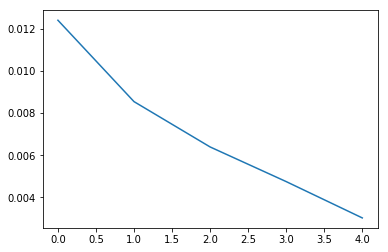

In [43]:
'''
Computing the covariance matrix from the stock returns data. 
The returns are the standardised stock returns, the basket parameter is the number of stocks in the basket.
The correlation in the covariance matrix can be calculated using Linear, Spearman and Kendal Tau correlation and the kind parameter corresponds to this.
'''
cov_mat=compute_cov_mat(returns,basket,kind='Spearman')

running_pl=np.zeros(basket,dtype=np.float)
running_dl=np.zeros(basket,dtype=np.float)
iterations=100000
rfr=0.02
maturity=5
for i in range(iterations):
    '''
    The probabilities of default are simulated using the joint distribution from copula. 
    The sampling can be performed from Gaussian or t-Student distribution. 
    The degrees of freedom can either be passed explicitely, or can be optimised using maximum log likelihood
    
    '''
    u=simulating_random_zhist(basket,cov_mat,'t-Student',returns,7,optimise=False)
    
    '''
    The default time is simulated from the the sampled probabilities of default and the marginal lambdas
    '''
    def_time,def_year=default_times(annual_lambdas,survival_probabilities,u)

    '''
    The premium and default leg are calculated then for the kth to default. 
    The basket weights parameter outlines the assets weights in the basket. 
    The rfr is the risk free rate and the rr is the recovery rate of the asset. 
    '''
    pppl,dddl = payments(def_time,def_year,rr,rfr,basket,basket_weights)
    
    running_pl+=pppl
    running_dl+=dddl


spread_value = np.array(running_dl)/np.array(running_pl)

print 'The average credit spread for kth to default probabilities is : {}'.format(spread_value)
plt.plot(spread_value)